In [1]:
import pandas as pd
from os.path import join
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats import normaltest

In [2]:
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [3]:
src = "../data/"
figures = "../figures/"
tables = "../tables/"

dtypes = pkl.load(open(join(src, "dtypes_config.pickle"), "rb"))

In [4]:
same_replies = pd.read_csv(join(src, "same_author_replies.csv"), 
                 dtype=dtypes,
                 usecols=["conversation_id", "Rating", 
                          "same_author_id", "anger_first"]
)
                 
user_data = same_replies.pivot_table(
        values='anger_first', 
        index='same_author_id', 
        columns='Rating'
    ).reset_index()

user_data.columns = ["author_id", "Untrustworthy", "Trustworthy"]
user_data

,author_id,Untrustworthy,Trustworthy
0,1007561,0.086956,0.938342
1,1013394,0.001823,0.005019
2,1018775,0.002033,0.996926
3,1019394,0.006804,0.001413
4,1020027,0.115911,0.114940
...,...,...,...
2567,9972097,0.873291,0.002836
2568,9973713,0.333169,0.009017
2569,9988855,0.946378,0.123456
2570,9993045,0.076547,0.949289


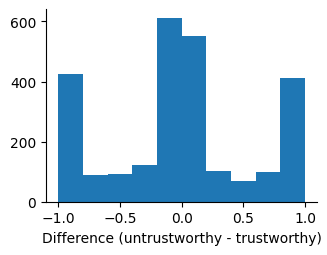

In [5]:
user_data['anger_diff'] = user_data['Untrustworthy'] - user_data['Trustworthy']
plt.figure(figsize=(3.5, 2.5))
plt.hist(user_data['anger_diff'])
plt.xlabel('Difference (untrustworthy - trustworthy)')
custom_plots()
plt.savefig(join(figures,"anger_diff.pdf"), dpi=300, bbox_inches='tight')

In [6]:
emotions = ["anger_first", "disgust_first", "fear_first", "sadness_first",
            "joy_first", "hope_first", "pride_first"]

coefs = pd.DataFrame()
for emotion in emotions:
    df = pd.read_csv(join("./users/", f"{emotion}_coefficients.csv"),
                     usecols=['parameter', 'estimate','pLL','pUL']
                     )
    df = df[df['parameter'] == 'Rating']
    df['Emotion'] = emotion.replace("_first", "").capitalize()
    df.rename(columns={'estimate': 'Estimate', 
                       'parameter': 'IV'}, 
                       inplace=True)
    coefs = pd.concat([coefs, df], ignore_index=True)

coefs_boot = pd.DataFrame()
for emotion in emotions:
    df = pd.read_csv(join("./users/", f"{emotion}_bootstraps.csv"),
                     usecols=['Rating'])
    df['Emotion'] = emotion.replace("_first", "").capitalize()

    coefs_boot = pd.concat([coefs_boot, df], ignore_index=True)

coefs_boot.head(2)

,Rating,Emotion
0,-0.005563,Anger
1,0.025122,Anger


/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

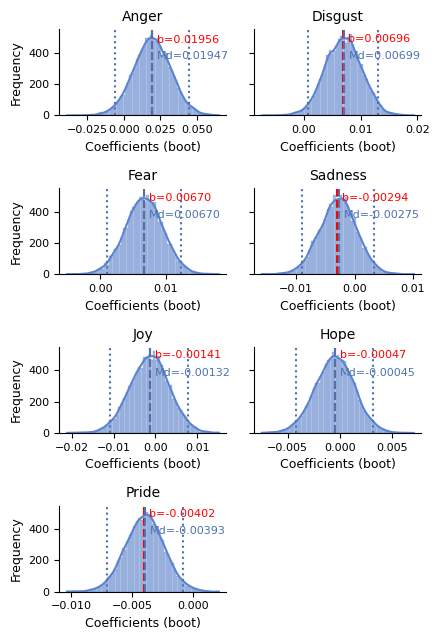

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(4.5, 6.5),
                        sharex=False, sharey=True)

for i, emotion in enumerate(coefs_boot["Emotion"].unique()):
    emo_row = coefs[coefs["Emotion"]==emotion]
    m_diff = emo_row["Estimate"].values[0]
    lower_ci = emo_row["pLL"].values[0]
    upper_ci = emo_row["pUL"].values[0]
    df = coefs_boot[coefs_boot["Emotion"] == emotion]
    median = df["Rating"].median()
    mean = df["Rating"].mean()
    sns.histplot(df["Rating"], 
                 ax=ax[i//2, i%2], color="#5A83D1", edgecolor="#4C72B0", kde=True)
    ax[i//2, i%2].set_title(emotion, fontsize=10)
    ax[i//2, i%2].set_xlabel("Coefficients (boot)", fontsize=9)
    ax[i//2, i%2].set_ylabel("Frequency", fontsize=9)
    ax[i//2, i%2].tick_params(axis="both", labelsize=8)

    ax[i // 2, i % 2].axvline(x=lower_ci,
                                    color="#4C72B0",
                                    linestyle=":")
    ax[i // 2, i % 2].axvline(x=upper_ci,
                                    color="#4C72B0",
                                    linestyle=":")
        
    ax[i//2, i%2].axvline(x=m_diff,
                            color="red",
                            linestyle="--")
    
    ax[i // 2, i % 2].text(
        m_diff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.9,
        f"b={m_diff:.5f}", 
        color="red", 
        fontsize=8,
        verticalalignment='center'
    )

    ax[i//2, i%2].axvline(x=median,
                            color="#4C72B0",
                            linestyle="--")
    
    ax[i // 2, i % 2].text(
        median + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.7,
        f"Md={median:.5f}", 
        color="#4C72B0", 
        fontsize=8,
        verticalalignment='center')
    
    custom_plots(ax=ax[i//2, i%2])
    
    # hide the last plot
    if i == 6:
        ax[3, 1].axis("off")

plt.tight_layout()


plt.savefig(join(figures, "same_coeff_res_boot.pdf"), 
                 bbox_inches="tight", 
                 dpi=300)
plt.show()

In [8]:
matched_discussions = pd.read_csv(join(src, 
                "matched_replies_mahalanobis.csv"),
                usecols=['conversation_id', 'Rating', 'anger_avg'],
                dtype=dtypes)
len(matched_discussions), matched_discussions.conversation_id.nunique()

(77318, 77318)

In [10]:
matched_first = pd.read_csv(join(src, 
                "matched_first_replies_mahalanobis.csv"),
                usecols=['conversation_id', 'Rating', 'anger_first'],
                dtype=dtypes)
len(matched_first), matched_first.conversation_id.nunique()

(77318, 77318)

In [11]:
starters = pd.read_csv(join(src,
                "discussions_starters.csv.gz"),
                usecols=['conversation_id', 'Rating'],
                dtype=dtypes)
len(starters), starters.conversation_id.nunique()

(9906260, 9906260)

In [12]:
starters.Rating.value_counts(dropna=False)

Rating
T    9310435
N     595824
S          1
Name: count, dtype: int64

In [13]:
discussions = pd.read_csv(join(src, 
                               "discussions_replies.csv.gz"), 
                            compression='gzip',
                            dtype=dtypes,
                            usecols=[
                            'conversation_id', 'author_id', 
                            'author.tweet_count', 
                            'anger', 'fear', 'disgust', 
                            'Orientation']
                    )\
                .merge(pd.read_csv(join(src,
                                        "discussions_replies_aggregates.csv"),
                            usecols=['conversation_id', 'Rating'],
                            dtype=dtypes),
                            on='conversation_id', how='right')
len(discussions), discussions.conversation_id.nunique()

(11688608, 852206)

In [14]:
discussions['Rating'] = discussions['Rating'].astype(str)\
    .replace({'0.0':'Trustworthy', 
              '1.0':'Untrustworthy'})
discussions.Rating.value_counts(dropna=False)

Rating
Trustworthy      11237196
Untrustworthy      451412
Name: count, dtype: int64

In [15]:
def safe_mode(x):
    if x.isna().all():
        return np.nan
    mode_result = x.mode()
    if len(mode_result) > 1:
        return "Neutral"
    return mode_result.iloc[0] if not mode_result.empty else np.nan

users_agg = pd.read_csv(join(src, "discussions_replies.csv.gz"),
                            compression="gzip", 
                            usecols=[
                                'author_id', 
                                'author.followers_count', 'author.following_count',
                                'author.tweet_count', 'anger', 'fear', 'disgust',
                                'sadness', 'joy', 'pride', 'hope', 'Orientation'])\
                    .groupby('author_id')\
                    .agg({
                        'author.followers_count': 'max',
                        'author.following_count': 'max',
                        'author.tweet_count': 'max',
                        'anger': 'mean',
                        'fear': 'mean',
                        'disgust': 'mean',
                        'sadness': 'mean',
                        'joy': 'mean',
                        'pride': 'mean',
                        'hope': 'mean',
                        'Orientation': safe_mode})\
                    .reset_index()
users_agg

,author_id,author.followers_count,author.following_count,author.tweet_count,anger,fear,disgust,sadness,joy,pride,hope,Orientation
0,1000012,1.0,93.0,13.0,0.995992,0.003827,0.004542,0.003373,0.001143,0.001413,0.001581,NaN
1,1000017,2.0,142.0,268.0,0.443815,0.001372,0.003667,0.002043,0.007716,0.001038,0.001876,Neutral
2,1000023,167.0,1310.0,2505.0,0.010787,0.000766,0.000748,0.000668,0.001095,0.000501,0.000483,NaN
3,1000030,32.0,193.0,689.0,0.426074,0.001694,0.012712,0.001438,0.001043,0.001051,0.000993,Left
4,1000058,468.0,588.0,5327.0,0.008147,0.000568,0.000594,0.000508,0.000647,0.000671,0.000560,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
397348,9999937,26.0,188.0,3402.0,0.307334,0.003108,0.010770,0.011337,0.011316,0.003369,0.001604,Left
397349,9999946,74.0,269.0,5440.0,0.272688,0.002828,0.002546,0.003898,0.026010,0.010888,0.002134,Neutral
397350,9999963,33.0,1394.0,3236.0,0.986417,0.004745,0.048394,0.004867,0.001506,0.001463,0.001466,NaN
397351,9999968,3981.0,117.0,3904.0,0.000622,0.000512,0.001019,0.000643,0.001487,0.000720,0.004849,NaN


In [16]:
users_agg.to_csv(join(src, "all_users_aggregated.csv"), index=False)

In [17]:
def safe_mode(x):
    if x.isna().all():
        return np.nan
    mode_result = x.mode()
    if len(mode_result) > 1:
        return "Neutral"
    return mode_result.iloc[0] if not mode_result.empty else np.nan

counts = discussions\
    .groupby(['conversation_id', 'Rating'])\
        .size()\
        .reset_index(name='n_replies')

discussions_agg = discussions\
                .groupby(['conversation_id', 'Rating'])\
                .agg({
                    'author_id': 'nunique',
                    'anger': 'mean',
                    'fear': 'mean',
                    'disgust': 'mean',
                    'Orientation': safe_mode})\
                    .reset_index()

discussions_agg = discussions_agg.merge(counts, on=['conversation_id', 'Rating'])
discussions_agg

,conversation_id,Rating,author_id,anger,fear,disgust,Orientation,n_replies
0,1311458383812276224,Trustworthy,2,0.496276,0.001799,0.001280,Right,2
1,1311462162708279297,Trustworthy,2,0.408648,0.050171,0.002131,Right,2
2,1311462180391395329,Trustworthy,9,0.405984,0.005817,0.001536,Neutral,10
3,1311462201052540929,Trustworthy,41,0.380542,0.004201,0.004938,Neutral,71
4,1311463707688546305,Trustworthy,11,0.445145,0.005594,0.032921,Neutral,32
...,...,...,...,...,...,...,...,...
852201,1509309133211815936,Trustworthy,16,0.436097,0.004305,0.007659,Left,29
852202,1509310013759803392,Trustworthy,2,0.211234,0.002411,0.026456,Neutral,2
852203,1509310516736368643,Trustworthy,10,0.317544,0.001872,0.002476,Left,11
852204,1509313664221810688,Trustworthy,2,0.150840,0.006264,0.002763,Neutral,2


In [18]:
def summarize_authors(df):
    n_users = df['author_id'].nunique()
    n_discussions = df['conversation_id'].nunique()
    n_replies = len(df)

    author_freq = df['author_id']\
                    .value_counts()\
                    .reset_index()\
                    .rename(columns={
                        'count': 'n_replies'})

    # calculate percentage of replies per user
    # author_freq['replies_perc'] = author_freq['n_replies'] / n_replies * 100

    # calculate cumulative percentage
    author_freq = author_freq.sort_values('n_replies', 
                                          ascending=False)\
                             .reset_index(drop=True)
    author_freq['cum_replies'] = author_freq['n_replies'].cumsum()
    author_freq['cum_perc'] = author_freq['cum_replies'] / n_replies * 100
    author_freq['user_perc'] = (np.arange(len(author_freq)) + 1) / len(author_freq) * 100

    cutoff = np.argmax(author_freq["cum_perc"] >= 80)
    p_80 = author_freq.iloc[cutoff]["user_perc"]

    # keep users until X% of the replies
    users_for_80 = (author_freq['cum_perc'] <= 80).sum()

    # create a df in long format
    summary = pd.DataFrame({'n_discussions': n_discussions,
                            'n_replies': n_replies,
                            'n_users': n_users,
                            'users_for_80': users_for_80,
                            'p_80': p_80},
                            index=[0])

    return summary, author_freq, cutoff, p_80


total_summary, total_users, total_cutoff, total_perc = summarize_authors(discussions)

untrust_replies = discussions[discussions['Rating'] == 'Untrustworthy']
trust_replies = discussions[discussions['Rating'] == 'Trustworthy']

untrust_replies_summary, untrust_users, untrust_cutoff, untrust_perc = summarize_authors(untrust_replies)
trust_replies_summary, trust_users, trust_cutoff, trust_perc = summarize_authors(trust_replies)

total_summary["Rating"] = "Total"
untrust_replies_summary["Rating"] = "Untrustworthy"
trust_replies_summary["Rating"] = "Trustworthy"

all_summary = pd.concat([total_summary, 
                         untrust_replies_summary, 
                         trust_replies_summary], 
                         ignore_index=True)
all_summary

,n_discussions,n_replies,n_users,users_for_80,p_80,Rating
0,852206,11688608,394783,37260,9.438350,Total
1,38659,451412,44536,7803,17.522903,Untrustworthy
2,813547,11237196,391188,37583,9.607657,Trustworthy


In [19]:
all_summary["users_for_80"] = all_summary["users_for_80"].astype(str) + " (" + all_summary["p_80"].round(1).astype(str) + "%)"

all_summary = all_summary.drop(columns=["p_80"])

summary_long = pd.melt(all_summary, id_vars=["Rating"], var_name="N", value_name="Value")
user_table = summary_long.pivot(index="N", columns="Rating", values="Value").reset_index()
user_table.columns.name = None  # remove the hierarchical column name

# reorder columns
user_table = user_table[["N", "Untrustworthy", "Trustworthy", "Total"]]
user_table.columns = ["N", "Untrustworthy", "Trustworthy", "Total"]

# rename N variables
user_table["N"] = user_table["N"]\
        .str.replace("n_", "")\
        .str.replace("_for_", " (")\
        .str.replace("0", "0%)")\
        .str.capitalize()
user_table

,N,Untrustworthy,Trustworthy,Total
0,Discussions,38659,813547,852206
1,Replies,451412,11237196,11688608
2,Users,44536,391188,394783
3,Users (80%),7803 (17.5%),37583 (9.6%),37260 (9.4%)


In [20]:
user_table_latex = user_table.replace("%", "\\%", regex=True)
user_table_latex

,N,Untrustworthy,Trustworthy,Total
0,Discussions,38659,813547,852206
1,Replies,451412,11237196,11688608
2,Users,44536,391188,394783
3,Users (80\%),7803 (17.5\%),37583 (9.6\%),37260 (9.4\%)


In [22]:
user_table_latex.to_latex(join(tables, "user_table.tex"), index=False, escape=False)

In [23]:
ratings_per_author = discussions\
                        .groupby('author_id')['Rating']\
                        .value_counts()\
                        .unstack(fill_value=0)

total_authors = len(ratings_per_author)
authors_trustworthy = ratings_per_author['Trustworthy'] > 0
authors_untrustworthy = ratings_per_author['Untrustworthy'] > 0
authors_only_trustworthy = (ratings_per_author['Trustworthy'] > 0) & (ratings_per_author['Untrustworthy'] == 0)
authors_only_untrustworthy = (ratings_per_author['Untrustworthy'] > 0) & (ratings_per_author['Trustworthy'] == 0)
authors_both_types = (ratings_per_author['Trustworthy'] > 0) & (ratings_per_author['Untrustworthy'] > 0)


summary_data = {
    'Rating': ['Trustworthy', 'Only trustworthy', 'Untrustworthy', 'Only untrustworthy', 'Both', 'Total'],
    'Count': [
        authors_trustworthy.sum(),
        authors_only_trustworthy.sum(),
        authors_untrustworthy.sum(),
        authors_only_untrustworthy.sum(), 
        authors_both_types.sum(),
        total_authors
    ],
    'Percentage': [
        f"{authors_trustworthy.sum() / total_authors * 100:.2f}%",
        f"{authors_only_trustworthy.sum() / total_authors * 100:.2f}%",
        f"{authors_untrustworthy.sum() / total_authors * 100:.2f}%",
        f"{authors_only_untrustworthy.sum() / total_authors * 100:.2f}%",
        f"{authors_both_types.sum() / total_authors * 100:.2f}%",
        "100.0%"
    ]
}

author_summary = pd.DataFrame(summary_data)
author_summary

,Rating,Count,Percentage
0,Trustworthy,391188,99.09%
1,Only trustworthy,350247,88.72%
2,Untrustworthy,44536,11.28%
3,Only untrustworthy,3595,0.91%
4,Both,40941,10.37%
5,Total,394783,100.0%


In [24]:
author_summary_latex = author_summary.replace("%", "\\%", regex=True)
author_summary_latex.to_latex(join(tables, "./rating_table.tex"), index=False, escape=False)

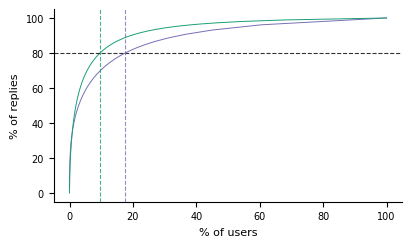

In [25]:
plt.figure(figsize=(4.5, 2.5))
plt.plot(untrust_users["user_perc"], untrust_users["cum_perc"], 
         label="Untrustworthy", color="#7570b3", linewidth=0.7)  
plt.plot(trust_users["user_perc"], trust_users["cum_perc"], 
         label="Trustworthy", color="#1b9e77", linewidth=0.7)

plt.axhline(80, color="black", linestyle="--", alpha=0.8, linewidth=0.8)
plt.axvline(untrust_perc, color="#7570b3", linestyle="--", alpha=0.8, linewidth=0.8)
plt.axvline(trust_perc, color="#1b9e77", linestyle="--", alpha=0.8, linewidth=0.8)

plt.xlabel("% of users", fontsize=8)
plt.ylabel("% of replies", fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=7)

custom_plots()

plt.show()

In [27]:
# extract the top users based on cutoff
untrust_users['author_id'] = untrust_users['author_id'].astype(str)
trust_users['author_id'] = trust_users['author_id'].astype(str)
users_agg['author_id'] = users_agg['author_id'].astype(str)

top_untrust = untrust_users.iloc[:untrust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_trust = trust_users.iloc[:trust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_untrust["group"] = "Untrustworthy"
top_trust["group"] = "Trustworthy"
top_users = pd.concat([top_untrust, top_trust], ignore_index=True)

In [30]:
stat1, p1 = normaltest(top_trust["anger"].dropna())
stat2, p2 = normaltest( top_untrust["anger"].dropna())

stat_var, p_var = stats.levene(top_trust["anger"].dropna(), top_untrust["anger"].dropna())

print(f"Normality test for Trustworthy: stat={stat1:.3f}, p={p1:.5f}")
print(f"Normality test for Untrustworthy: stat={stat2:.3f}, p={p2:.5f}")

Normality test for Trustworthy: stat=380.916, p=0.00000
Normality test for Untrustworthy: stat=200.297, p=0.00000


In [32]:
u_stat, p_value = stats.mannwhitneyu(top_trust["anger"].dropna(), 
                                        top_untrust["anger"].dropna(), 
                                        alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.3f}, p = {p_value:.5f}")

Mann-Whitney U test: U = 125151062.500, p = 0.00000


/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


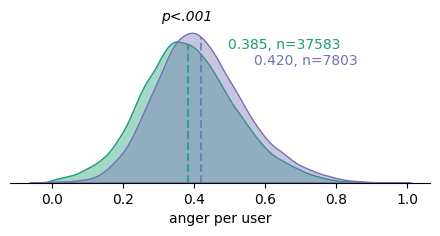

In [34]:
group_colors = {"Trustworthy": "#1b9e77", 
                "Untrustworthy": "#7570b3"}
group_labels = list(group_colors.keys())

fig, ax = plt.subplots(figsize=(4.5, 2.5))

stats_text = []
# ax.set_title("First replies", fontsize=12, pad=7,
#              loc='left')
for group, color in group_colors.items():
    rating_data = top_users[top_users['group'] == group]
    n_users = rating_data.author_id.nunique()
    group_data = top_users[top_users['group'] == group]["anger"].dropna()
    avg_value = group_data.mean()  

    sns.kdeplot(group_data, color=color, ax=ax, fill=True, alpha=0.4, label=group.capitalize())
    kde = gaussian_kde(group_data)
    density_at_mean = kde(avg_value)
    
    ax.vlines(
        avg_value, 
        ymin=0, 
        ymax=density_at_mean, 
        color=color, 
        linestyle="--", 
        linewidth=1.5,
        alpha=0.8
    )

    stats_text.append(f"{avg_value:.3f}, n={n_users}")

# add significance remark based on mann whitney test
ax.text(0.36, 1.1, "p<.001", 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        color="black",
        fontstyle='italic'
        )   

ax.set_xlabel("anger per user")
ax.set_ylabel("")
ax.set_yticks([])
ax.set_yticklabels([])
ax.spines['left'].set_visible(False)

stats_string = '\n'.join(stats_text)
ax.text(0.52, 0.92, f"{stats_text[0]}", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', color=group_colors["Trustworthy"])

ax.text(0.58, 0.82, f"{stats_text[1]}", 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', color=group_colors["Untrustworthy"])

custom_plots(ax)
plt.tight_layout()
plt.show()

In [35]:
ratings = pd.read_csv(join("users", "rating_coeffs.csv"))
ratings["Symbol"] = ratings["p"].apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else ""
)
ratings['IV'] = 'Rating'
sig_ratings = ratings[ratings['p'] < 0.05].copy()
anger = ratings[ratings['DV'] == 'Anger'].copy()
sig_ratings = pd.concat([sig_ratings, anger], ignore_index=True)
sig_ratings
print(sig_ratings)

        DV  Estimate        SE         t         p       pLL       pUL Symbol  \
0  Disgust  0.006964  0.003202  2.175063  0.029700  0.000800  0.013125      *   
1     Fear  0.006699  0.002858  2.344103  0.019135  0.001002  0.012289      *   
2    Pride -0.004019  0.001647 -2.440973  0.014703 -0.007083 -0.000800      *   
3    Anger  0.019558  0.013091  1.494010  0.135274 -0.005736  0.044905          

       IV  
0  Rating  
1  Rating  
2  Rating  
3  Rating  


In [36]:
all_sig_coeffs = pd.read_csv(join("users", "all_sig_coeffs.csv"))

all_sig_coeffs["IV"] = all_sig_coeffs["IV"]\
    .str.replace("author.", "")\
    .str.replace("_log", "")\
    .str.replace("_", " ")\
    .str.capitalize()\
    .replace("Followers count", "Followers")

all_sig_coeffs["Symbol"] = all_sig_coeffs["p"]\
    .apply(lambda x: "***" 
           if x < 0.001 else "**" 
           if x < 0.01 else "*" 
           if x < 0.05 else ""
)

all_sig_coeffs

,DV,IV,Estimate,SE,t,p,pLL,pUL,Symbol
0,Anger,Anger,0.165197,0.021145,7.812671,6.700000e-15,0.126280,0.206604,***
1,Anger,Disgust,0.241072,0.092664,2.601569,9.306599e-03,0.066864,0.413983,**
2,Anger,Sadness,0.193175,0.084122,2.296354,2.169577e-02,0.036421,0.353858,*
3,Anger,Hope,-0.407912,0.188577,-2.163110,3.057879e-02,-0.758113,-0.028872,*
4,Anger,Followers,-0.008706,0.004203,-2.071268,3.843194e-02,-0.016667,-0.000968,*
5,Disgust,Rating,0.006964,0.003202,2.175063,2.969998e-02,0.000800,0.013125,*
6,Disgust,Disgust,0.069328,0.022634,3.063074,2.202155e-03,0.033411,0.117575,**
7,Disgust,Sadness,0.055456,0.020545,2.699275,6.971854e-03,0.023488,0.100843,**
8,Fear,Rating,0.006699,0.002858,2.344103,1.913506e-02,0.001002,0.012289,*
9,Fear,Fear,0.048684,0.012844,3.790298,1.521975e-04,0.027820,0.076946,***


In [37]:
merged_ratings = pd.concat([sig_ratings, all_sig_coeffs], ignore_index=True)
merged_ratings

,DV,Estimate,SE,t,p,pLL,pUL,Symbol,IV
0,Disgust,0.006964,0.003202,2.175063,2.969998e-02,0.000800,0.013125,*,Rating
1,Fear,0.006699,0.002858,2.344103,1.913506e-02,0.001002,0.012289,*,Rating
2,Pride,-0.004019,0.001647,-2.440973,1.470284e-02,-0.007083,-0.000800,*,Rating
3,Anger,0.019558,0.013091,1.494010,1.352738e-01,-0.005736,0.044905,,Rating
4,Anger,0.165197,0.021145,7.812671,6.700000e-15,0.126280,0.206604,***,Anger
5,Anger,0.241072,0.092664,2.601569,9.306599e-03,0.066864,0.413983,**,Disgust
6,Anger,0.193175,0.084122,2.296354,2.169577e-02,0.036421,0.353858,*,Sadness
7,Anger,-0.407912,0.188577,-2.163110,3.057879e-02,-0.758113,-0.028872,*,Hope
8,Anger,-0.008706,0.004203,-2.071268,3.843194e-02,-0.016667,-0.000968,*,Followers
9,Disgust,0.006964,0.003202,2.175063,2.969998e-02,0.000800,0.013125,*,Rating
